In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass, field, fields
from typing import List, Dict, Tuple
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from copy import deepcopy
import os


## Configs

In [2]:

@dataclass
class Configs:
    
    #...general params:
    WORKDIR : str = './'   
    DEVICE : str = 'cuda:0'
    MULTI_GPU : bool = True

    #...data params:
    DATA : str = None
    DATA_TARGET : str = 'cifar10'
    DATA_SOURCE : str = 'noise'
    DIM_INPUT : int = None
    INPUT_SHAPE : Tuple[float] = field(default_factory = lambda : (3, 32, 32))
    
    #...model params:
    MODEL : str = 'Unet32x32'
    NUM_CHANNELS : int = 64
    CHANNEL_MULT : List[float] = field(default_factory = lambda : [1, 2, 2, 2])
    NUM_RES_BLOCKS : int = 2
    NUM_HEADS : int = 4
    DIM_HIDDEN : int = 64 
    ATTENTION_RESOLUTIONS : str = "16"
    DROPOUT : float = 0.1

    #...training params:
    BATCH_SIZE : int = 128
    DATA_SPLIT_FRACS : List[float] = field(default_factory = lambda : [1.0, 0.0, 0.0])  # train / val / test 
    EPOCHS: int = 5
    EARLY_STOPPING : int = None
    MIN_EPOCHS : int = None 
    PRINT_EPOCHS : int = None   
    FIX_SEED : int = None  
    NUM_WORKERS : int = 0
    PIN_MEMORY: bool = False

    #...cfm params:
    DYNAMICS : str = 'CondFlowMatch'
    SIGMA : float = 0.001
    AUGMENTED : bool = False
    T0 : float = 0.0
    T1 : float = 1.0

    #...optimization & scheduler params:
    OPTIMIZER: str = 'Adam'
    LR : float = 1e-4
    WEIGHT_DECAY : float = 0.0
    OPTIMIZER_BETAS : List[float] = field(default_factory = lambda : [0.9, 0.999])
    OPTIMIZER_EPS : float = 1e-8
    OPTIMIZER_AMSGRAD : bool = False
    GRADIENT_CLIP : float = None
    SCHEDULER: str = None
    SCHEDULER_T_MAX: int = None
    SCHEDULER_ETA_MIN: float = None
    SCHEDULER_GAMMA: float = None
    SCHEDULER_STEP_SIZE: int = None

    #...generation pipeline params:
    SAMPLER : str = 'NeuralODE'
    SOLVER : str = 'euler'
    NUM_SAMPLING_STEPS : int = 100
    SENSITIVITY : str = 'adjoint'
    ATOL : float = None
    RTOL : float = None
    NUM_GEN_SAMPLES: int = 10 


    def __post_init__(self):
        self.DATA = self.DATA_SOURCE + '_to_' + self.DATA_TARGET
        self.DIM_INPUT = np.prod(self.INPUT_SHAPE)
        if self.MULTI_GPU: self.DEVICE = 'cuda:0'


## Datamodule

INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 50000, validation size: 0, testing sizes: 0


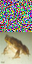

In [3]:
from cmb.data.cifar import CIFARDataClass
from cmb.data.utils import DefineDataloader

conf = Configs()
cifar = CIFARDataClass(conf)
dataloader = DefineDataloader(cifar)
transform = ToPILImage()

for batch in dataloader.train:
    pair = torch.cat([batch.source[0].squeeze(), batch.target[0].squeeze()], dim=1)
    img = transform(pair)
    break

img

## Train CFM model on CIFAR-10

In [4]:
from cmb.dynamics.cfm import ConditionalFlowMatching
from cmb.models.architectures.unet_cifar import UNet32x32 

dynamics = ConditionalFlowMatching(conf)
unet = UNet32x32(conf)


2024-07-22 13:10:21.996570: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 13:10:22.034531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 13:10:22.035252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 13:10:22.768049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from cmb.models.trainers import CFMTrainer
cfm_model = CFMTrainer(dynamics, unet, cifar)
cfm_model.train()

number of training parameters: 8952067
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 50000, validation size: 0, testing sizes: 0
INFO: using  4 GPUs...


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

## image generation

In [6]:
from cmb.models.pipelines import CFMPipeline

pipeline = CFMPipeline(trained_model=cfm_model, config=conf)
input_source = torch.randn(conf.BATCH_SIZE, *conf.INPUT_SHAPE)
pipeline.generate_samples(input_source)

INFO: neural ODE solver with euler method and steps=100


  0%|          | 0/1 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


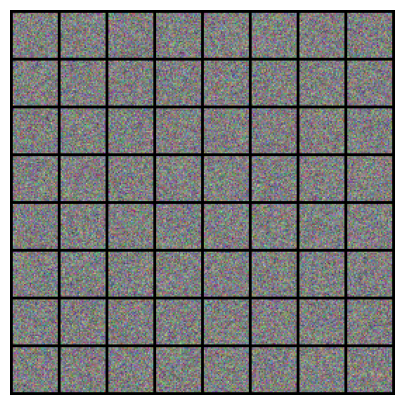

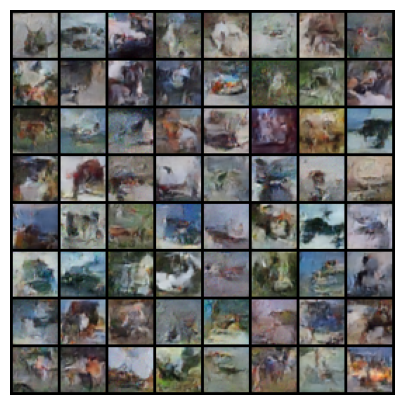

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt

img_generated = pipeline.trajectories[-1, :] 

grid_img_gen = torchvision.utils.make_grid(img_generated[:64], nrow=8, padding=2, normalize=True)
grid_img_src = torchvision.utils.make_grid(input_source[:64], nrow=8, padding=2, normalize=True)


plt.figure(figsize=(5, 5))
plt.imshow(grid_img_src.permute(1, 2, 0))  # Permute the dimensions to (H, W, C) for plotting
plt.axis('off')  # Turn off the axis
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(grid_img_gen.permute(1, 2, 0))  # Permute the dimensions to (H, W, C) for plotting
plt.axis('off')  # Turn off the axis
plt.show()


## FID computation

In [ ]:
from cleanfid import fid
score = fid.compute_fid(
    gen=img,
    dataset_name="cifar10",
    batch_size=16,
    dataset_res=128,
    num_gen=128,
    dataset_split="train",
    mode="legacy_tensorflow",
)
print()
print("FID has been computed")
print()
print("FID: ", score)
